# Demo for using pydmp for data fetching and analysis

<h4 style="color:orange;">Pydmp is a python wrapper of the DMP APIs, providing support for reading data in various ways.</h4>

To do:
- Everything should be a function
- There should be a data preprocessing pipeline
- to remove outliers about 2.5
- Also some missing latitude and longitude really

<h2 style="color:#0074D9;">1. List available datasets.</h2>

In [2]:
from pydmp import state
state()

Connected to 1 studies:
Connected to 1 studies:
You have access to 1 studies:
0b53d635-e3eb-4054-855e-485c5268b7c6 = AI-RESPIRE


<h4 style="color:orange;">Pydmp for now supports two granularities to read the data:</h4>
<h4 style="color:orange;">&nbsp;&nbsp;&nbsp;&nbsp;a. Reading a whole file each time.</h4>
<h4 style="color:orange;">&nbsp;&nbsp;&nbsp;&nbsp;b. Reading individual data clips (a value of a cell in the csv or xlsx sheet).</h4>
<h4 style="color:orange;">Other granularities can be further developed depending on real user cases.</h4>


<h2 style="color:#0074D9;">2. List available files of a study.</h2>

In [ ]:
from pydmp import list_files
study_id = '0b53d635-e3eb-4054-855e-485c5268b7c6'
files = list_files(study_id=study_id, format='df') # list
files

<h2 style="color:#0074D9;">3. Fetch the content of a file (csv, xlsx).</h2>

In [4]:
from pydmp import read_file
content = read_file(file=files.iloc[0])
content.head(2)

,Unnamed: 0,subject,season,peak_pred,day,peak_am,peak_pm
0,756,INH101,Winter,553,1,,
1,757,INH101,Summer,553,1,,


In [ ]:
import pandas as pd
respiratory_data = read_file(file=files.iloc[14])
pollution_data = read_file(file=files.iloc[13])
respiratory_data

# DATASETS PIPELINE CLEANING

In [ ]:
import pandas as pd
# Ensure timestamp is datetime
respiratory_data['timestamp'] = pd.to_datetime(respiratory_data['timestamp'])
pollution_data['timestamp'] = pd.to_datetime(pollution_data['timestamp'])

# Check for duplicate keys
dupes = respiratory_data[respiratory_data.duplicated(subset=['timestamp', 'patient_id'], keep=False)]
dupes.sort_values(['patient_id', 'timestamp'])

dupes
## The below are the duplicated data!!!!

In [ ]:
## let's drop duplicates for now
respiratory_data_dropping_duplicates = respiratory_data.drop_duplicates()
respiratory_data_nd = respiratory_data_dropping_duplicates.drop(columns=["Unnamed: 0"])
pollution_data_dropping_duplicates = pollution_data.drop_duplicates() 
pollution_data_nd = pollution_data_dropping_duplicates.drop(columns=["Unnamed: 0"])
respiratory_data_nd

In [ ]:
## Check how many NaNs per patient_id
# Percentage of NaNs per column, grouped by patient_id
nan_percent_per_column_per_patient = (
    respiratory_data_nd
    .groupby('patient_id')
    .apply(lambda df: df.isna().sum() / len(df) * 100)
)
# round for readability
nan_percent_per_column_per_patient = nan_percent_per_column_per_patient.round(2)

sorted = nan_percent_per_column_per_patient.sort_values("br_avg")
sorted

In [ ]:
# Group by patient, compute std only on numeric columns
flatness_check = (
    respiratory_data_nd
    .groupby('patient_id')
    .agg({ 
        'br_avg': 'std', 
        'br_std': 'std', 
        'act_level': 'std', 
        'step_count': 'std'
    })
)

print(flatness_check)


In [ ]:
## Check how many NaNs per patient_id
# Percentage of NaNs per column, grouped by patient_id
nan_percent_per_column_pollution = (
    pollution_data_nd
    .groupby('patient_id')
    .apply(lambda df: df.isna().sum() / len(df) * 100)
)

nan_percent_per_column_pollution

## No pollution columns need to be dropped!

In [ ]:
## For now I am gonna go safe and drop duplicates as well as dropna and then I can discuss:
patient_exlcuded = ["INH016", "INH019","INH026", "INH126", "INH136"]	
resp_data_clean = respiratory_data_nd[~respiratory_data_nd["patient_id"].isin(patient_exlcuded)]
resp_data_clean

In [12]:
## also dropping na for the two datasets:
## Respiratory data:
resp_data_clean_na = resp_data_clean.dropna()

## Pollution data:
pollution_data_clean_na = pollution_data_nd.dropna()


## MERGING DATASETS 

In [13]:
## I am going to merge the datasets based on timestamp and patient_id
## if there is no alignment, for now I will discard the data

# Merge the two tables on both patient_id and timestamp
merged_data = pd.merge(
    resp_data_clean_na,
    pollution_data_clean_na,
    on=['patient_id', 'timestamp'],
    how='inner'  # or 'inner' if you only want matching rows
)

## Let's check which ids are in one but not in the other!

id_resp = resp_data_clean_na["patient_id"].unique()
id_pollution = pollution_data_clean_na["patient_id"].unique()

non_matching_id = []

for i in id_resp:
    if i in id_pollution:
        pass
    else: non_matching_id.append(i)

print(non_matching_id, print(len(resp_data_clean_na)), print(len(pollution_data_clean_na)))

1058553
1228132
['INH029'] None None


In [14]:
len(merged_data["patient_id"].unique())

51

In [15]:
import numpy as np
merged_cyclical = merged_data.copy()
merged_cyclical = merged_cyclical.sort_values(['patient_id', 'timestamp']).reset_index(drop=True)

# ## Now let's pslit by chuncks where data is closed together - in term of time difference

merged_cyclical['time_diff'] = merged_cyclical.groupby('patient_id')['timestamp'].diff() ## Adding difference between that and the previous one 

merged_cyclical['new_segment'] = merged_cyclical['time_diff'] > pd.Timedelta(minutes=1)
merged_cyclical['segment_id'] = merged_cyclical.groupby('patient_id')['new_segment'].cumsum()



# # Count rows per (patient_id, segment_id)
segment_lengths = merged_cyclical.groupby(['patient_id', 'segment_id']).size().reset_index(name='length')

# # Keep only those with enough length
min_points = 30  # e.g. 60 minutes of data
valid_segments = segment_lengths[segment_lengths['length'] >= min_points]

# # Merge back to original df to filter
merged_cyclical = merged_cyclical.merge(valid_segments[['patient_id', 'segment_id']], on=['patient_id', 'segment_id'], how='inner')

merged_cyclical

def apply_cyclical(block):
    # Extract components from timestamp
    block['hour'] = block['timestamp'].dt.hour
    block['dow'] = block['timestamp'].dt.dayofweek           # 0 = Monday, 6 = Sunday
    block['day_of_year'] = block['timestamp'].dt.dayofyear    # 1 to 365

    # Hourly (circadian)
    block['hour_sin'] = np.sin(2 * np.pi * block['hour'] / 24)
    block['hour_cos'] = np.cos(2 * np.pi * block['hour'] / 24)

    # Weekly
    block['dow_sin'] = np.sin(2 * np.pi * block['dow'] / 7)
    block['dow_cos'] = np.cos(2 * np.pi * block['dow'] / 7)

    # Yearly (seasonality)
    block['yearly_sin'] = np.sin(2 * np.pi * block['day_of_year'] / 365)
    block['yearly_cos'] = np.cos(2 * np.pi * block['day_of_year'] / 365)

    return block

merged_continuous_blocks = apply_cyclical(merged_cyclical)

In [ ]:
merged_continuous_blocks


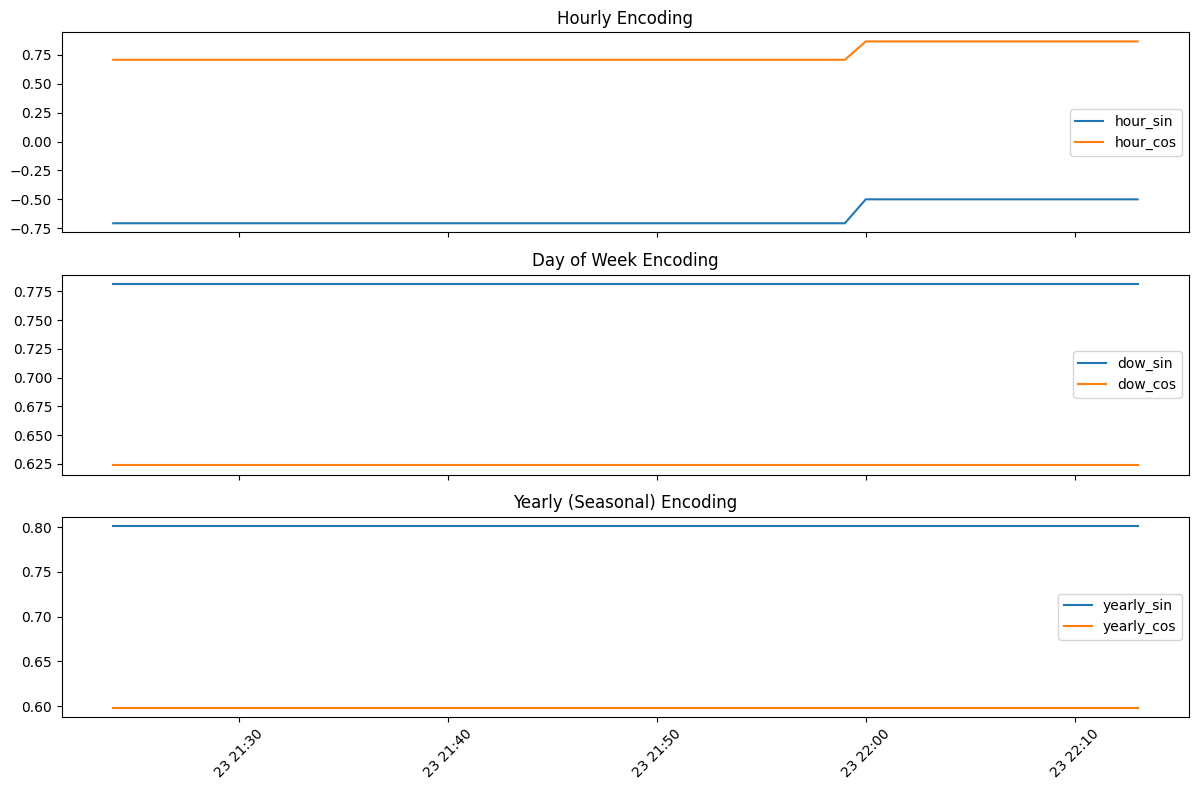

In [17]:
import matplotlib.pyplot as plt

def plot_cyclical_features(df, patient_id, segment_id):
    block = df[(df['patient_id'] == patient_id) & (df['segment_id'] == segment_id)].copy()

    if block.empty:
        print(f"No data found for patient {patient_id}, segment {segment_id}")
        return

    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    axs[0].plot(block['timestamp'], block['hour_sin'], label='hour_sin')
    axs[0].plot(block['timestamp'], block['hour_cos'], label='hour_cos')
    axs[0].legend()
    axs[0].set_title('Hourly Encoding')

    axs[1].plot(block['timestamp'], block['dow_sin'], label='dow_sin')
    axs[1].plot(block['timestamp'], block['dow_cos'], label='dow_cos')
    axs[1].legend()
    axs[1].set_title('Day of Week Encoding')

    axs[2].plot(block['timestamp'], block['yearly_sin'], label='yearly_sin')
    axs[2].plot(block['timestamp'], block['yearly_cos'], label='yearly_cos')
    axs[2].legend()
    axs[2].set_title('Yearly (Seasonal) Encoding')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
plot_cyclical_features(merged_continuous_blocks, patient_id='INH001', segment_id=100)


In [18]:
valid_counts = merged_continuous_blocks.groupby(['patient_id', 'segment_id']).size()
print(f"Total valid continuous segments: {valid_counts.shape[0]}")


Total valid continuous segments: 7018


## OPENWEATHER API REQUEST

In [19]:
# # ## ----------------------------------------------------------
# # ## Create a list of unique timestamp in hour cause openweather is in hour
# # ## patient_id longitude and latitude per user so that I can download equivalent data from OpenWeather
# # ## this is a massive limitation! Only hourly pollution level is not enough
# # ## ----------------------------------------------------------

# ## 
# # import pandas as pd

# pat_choose = ['INH001', 'INH002', 'INH003', 'INH004', 'INH005', 'INH006']

# merge_data_pat_id = merge_data_selected_columns[merge_data_selected_columns["patient_id"].isin(pat_choose)].copy()

# merge_data_pat_id['timestamp_hour'] = pd.to_datetime(merge_data_pat_id['timestamp']).dt.floor('H')

# merge_data_pat_id
# # # # # # # 3. Select only the relevant columns for API querying
# weather_query_cols = ['timestamp_hour', 'latitude', 'longitude']

# # # merge_data_pat_id
# # # # # # # 4. Drop duplicates to minimize API requests
# unique_weather_queries = merge_data_pat_id[weather_query_cols].drop_duplicates()

# # # # # # # 6. Preview
# print(unique_weather_queries)

# # unique_weather_queries.to_csv("request135_139.csv")

## NOW ADDING OPENWEATHER DATA AND MERGING ALTOGETHER

In [20]:
# ----------------------------------------------------------------- 
# Step 1: Import and Concatenate OpenWeather Files
# ----------------------------------------------------------------- 

pollution_results_incremental001_006 = pd.read_csv("pollution_results_incremental001_006.csv")
pollution_results_incremental007_013 = pd.read_csv("pollution_results_incremental007_013.csv")
pollution_results_incremental014_023 = pd.read_csv("pollution_results_incremental014_023.csv") 
pollution_results_incremental024_101 = pd.read_csv("pollution_results_incremental024_101.csv")
pollution_results_incremental102_109 = pd.read_csv("pollution_results_incremental102_109.csv")
pollution_results_incremental110_115 = pd.read_csv("pollution_results_incremental110_115.csv")
pollution_results_incremental117_124 = pd.read_csv("pollution_results_incremental117_124.csv")
pollution_results_incremental127_132 = pd.read_csv("pollution_results_incremental127_132.csv")
pollution_results_incremental135_139 = pd.read_csv("pollution_results_incremental135_139.csv")

# Add more CSVs here if needed

concat_openweather = pd.concat([
    pollution_results_incremental001_006,
    pollution_results_incremental007_013, 
    pollution_results_incremental014_023,
    pollution_results_incremental024_101,
    pollution_results_incremental102_109,
    pollution_results_incremental110_115,
    pollution_results_incremental117_124,
    pollution_results_incremental127_132,
    pollution_results_incremental135_139
])

# Convert and rename timestamp
concat_openweather["start_time"] = pd.to_datetime(concat_openweather["start_time"], unit='s')
concat_openweather["end_time"] = pd.to_datetime(concat_openweather["end_time"], unit='s')
concat_openweather = concat_openweather.rename(columns={"start_time": "timestamp"})

# FLOOR to hour NOW — this is critical
concat_openweather['timestamp_hour'] = concat_openweather['timestamp'].dt.floor('H')

# Round lat/lon
concat_openweather['lat_round'] = concat_openweather['latitude'].round(3)
concat_openweather['lon_round'] = concat_openweather['longitude'].round(3)

# Aggregate on floored hour and rounded location
concat_openweather_agg = (
    concat_openweather
    .groupby(['timestamp_hour', 'lat_round', 'lon_round'])
    .mean(numeric_only=True)
    .reset_index()
)

concat_openweather

,latitude,longitude,timestamp,end_time,AQI,pm2_5,pm10,no,no2,o3,so2,co,timestamp_hour,lat_round,lon_round
0,51.490046,-0.174493,2021-02-23 09:00:00,2021-02-23 10:00:00,1.0,1.72,2.34,0.67,12.85,72.24,4.77,230.31,2021-02-23 09:00:00,51.490,-0.174
1,51.490047,-0.174500,2021-02-23 09:00:00,2021-02-23 10:00:00,1.0,1.72,2.34,0.67,12.85,72.24,4.77,230.31,2021-02-23 09:00:00,51.490,-0.175
2,51.490049,-0.174472,2021-02-23 09:00:00,2021-02-23 10:00:00,1.0,1.72,2.34,0.67,12.85,72.24,4.77,230.31,2021-02-23 09:00:00,51.490,-0.174
3,51.490052,-0.174474,2021-02-23 09:00:00,2021-02-23 10:00:00,1.0,1.72,2.34,0.67,12.85,72.24,4.77,230.31,2021-02-23 09:00:00,51.490,-0.174
4,51.490128,-0.174413,2021-02-23 09:00:00,2021-02-23 10:00:00,1.0,1.72,2.34,0.67,12.85,72.24,4.77,230.31,2021-02-23 09:00:00,51.490,-0.174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47369,51.472433,-0.209053,2023-10-10 23:00:00,2023-10-11 00:00:00,2.0,10.33,18.25,0.00,11.82,68.66,5.07,206.95,2023-10-10 23:00:00,51.472,-0.209
47370,51.472422,-0.209052,2023-10-10 23:00:00,2023-10-11 00:00:00,2.0,10.33,18.25,0.00,11.82,68.66,5.07,206.95,2023-10-10 23:00:00,51.472,-0.209
47371,51.472418,-0.209052,2023-10-10 23:00:00,2023-10-11 00:00:00,2.0,10.33,18.25,0.00,11.82,68.66,5.07,206.95,2023-10-10 23:00:00,51.472,-0.209
47372,51.472421,-0.209044,2023-10-10 23:00:00,2023-10-11 00:00:00,2.0,10.33,18.25,0.00,11.82,68.66,5.07,206.95,2023-10-10 23:00:00,51.472,-0.209


In [21]:
# ----------------------------------------------------------------- 
# MERGING INHALE WITH OPENWEATHER
# ----------------------------------------------------------------- 

## The problem that I have now is that merge_data_selected_columns is minute level
## while openweather is hourly level
## I will then merge the 2 dataframes on hour for openweather, and hour the minutes belong to 
## for INHALE dataset

print(merged_continuous_blocks["timestamp"].head())  # from pollution data
print(concat_openweather["timestamp"].head())  # from physiological/GPS data 

## Before I merge let's extract the hour
# Floor timestamps to the hour
merged_continuous_blocks['timestamp_hour'] = pd.to_datetime(merged_continuous_blocks['timestamp']).dt.floor('H')


# Prepare INHALE data
merged_continuous_blocks['timestamp_hour'] = pd.to_datetime(merged_continuous_blocks['timestamp']).dt.floor('H')
merged_continuous_blocks['lat_round'] = merged_continuous_blocks['latitude'].round(3)
merged_continuous_blocks['lon_round'] = merged_continuous_blocks['longitude'].round(3)

# Merge
merged_inhale_openweather = pd.merge(
    merged_continuous_blocks,
    concat_openweather_agg,
    on=['timestamp_hour', 'lat_round', 'lon_round'],
    how='inner'
)

diagnostic_merge = pd.merge(
    merged_continuous_blocks,
    concat_openweather_agg,
    on=['timestamp_hour', 'lat_round', 'lon_round'],
    how='outer',
    indicator=True
)
print("Diagnostic merge:", diagnostic_merge['_merge'].value_counts())

# Confirm row reduction
print(f"Merged shape: {merged_inhale_openweather.shape}")
print(f"INHALE base rows: {merged_continuous_blocks.shape}")
print(f"OpenWeather unique hour-loc rows: {concat_openweather_agg.shape}")

0   2021-02-23 21:24:00
1   2021-02-23 21:25:00
2   2021-02-23 21:26:00
3   2021-02-23 21:27:00
4   2021-02-23 21:28:00
Name: timestamp, dtype: datetime64[ns]
0   2021-02-23 09:00:00
1   2021-02-23 09:00:00
2   2021-02-23 09:00:00
3   2021-02-23 09:00:00
4   2021-02-23 09:00:00
Name: timestamp, dtype: datetime64[ns]
Diagnostic merge: _merge
both          533012
right_only     32907
left_only          0
Name: count, dtype: int64
Merged shape: (533012, 40)
INHALE base rows: (533012, 31)
OpenWeather unique hour-loc rows: (54606, 12)


In [22]:
merged_inhale_openweather.columns

Index(['patient_id', 'age', 'sex', 'timestamp', 'season_x', 'br_avg', 'br_std',
       'act_level', 'step_count', 'activity', 'latitude_x', 'longitude_x',
       'season_y', 'pm2_5_x', 'temperature', 'humidity', 'time_diff',
       'new_segment', 'segment_id', 'hour', 'dow', 'day_of_year', 'hour_sin',
       'hour_cos', 'dow_sin', 'dow_cos', 'yearly_sin', 'yearly_cos',
       'timestamp_hour', 'lat_round', 'lon_round', 'latitude_y', 'longitude_y',
       'pm2_5_y', 'pm10', 'no', 'no2', 'o3', 'so2', 'co'],
      dtype='object')

In [23]:
# ----------------------------------------------------------------- 
# DROPPING NOT NEEDED COLUMNS AND THEN EDA
# ----------------------------------------------------------------- 

## To check:]
## 1: Drop non needed columns 

# 1: I will drop:
# timestamp_y becuase not needed
# 'latitude_y', 'longitude_y' I have it from Inhale
# 'end_time', I already have timestamp

# Check if latitude and longitude from both sources are identical
merged_check = merged_inhale_openweather.copy()
merged_check['lat_diff'] = merged_check['latitude_x'] - merged_check['latitude_y']
merged_check['lon_diff'] = merged_check['longitude_x'] - merged_check['longitude_y']

# Summarize any differences
print(merged_check[['lat_diff', 'lon_diff']].describe())

## As we can see differences are minimals so we can drop lat long y


merged_inhale_openweather_dropped = merged_inhale_openweather.drop(columns= ["latitude_y","longitude_y"])

           lat_diff      lon_diff
count  5.330120e+05  5.330120e+05
mean  -1.949559e-07  4.761220e-07
std    5.192500e-05  7.240830e-05
min   -7.540385e-04 -8.251676e-04
25%   -1.236400e-05 -1.799250e-05
50%    0.000000e+00  0.000000e+00
75%    1.281488e-05  1.808245e-05
max    6.981417e-04  8.693057e-04


## OUTLIERS REMOVAL AND N0RMALISATION

In [24]:
## 1: Outliers?
## 2: Column by column checking
## Normnalisation and log scaling skewed etc

## Dropping not needed

merged_inhale_openweather_dropped.columns

Index(['patient_id', 'age', 'sex', 'timestamp', 'season_x', 'br_avg', 'br_std',
       'act_level', 'step_count', 'activity', 'latitude_x', 'longitude_x',
       'season_y', 'pm2_5_x', 'temperature', 'humidity', 'time_diff',
       'new_segment', 'segment_id', 'hour', 'dow', 'day_of_year', 'hour_sin',
       'hour_cos', 'dow_sin', 'dow_cos', 'yearly_sin', 'yearly_cos',
       'timestamp_hour', 'lat_round', 'lon_round', 'pm2_5_y', 'pm10', 'no',
       'no2', 'o3', 'so2', 'co'],
      dtype='object')

In [25]:
# ----------------------------------------------------------------- 
# OUTLIERS ANALYSIS AND REMOVAL
# ----------------------------------------------------------------- 

# 1. I am going to describe the dataset first and identify where the outliers are
# 2. I will then plot them with a boxplot

## You can see straight away there are outliers in:
# a. Does a value of 44 makes sense? Could it be that the patient was maybe just doing sport? 
# b. Is an activity level higher than 1 actually possible? I asked hisham!
# c. pm2_5 definitely has an outlier, this is because a max of 2245 would hurt or kill a person instantly.
# d. Same thing with temperature really! I struggle to believe a temperature of 56 degrees. 
## pm2.5x since the mean is 4 but the max is 2245, same with temperature. Also cause pm2.5y which is the same just not as granular is 
## has a max of 50.
## e. I am also curious to focus on pollution measures to see those spikes!
print(merged_inhale_openweather_dropped.describe())

                 age                      timestamp         br_avg  \
count  533012.000000                         533012  533012.000000   
mean       44.286570  2022-04-09 20:10:22.382872832      16.193674   
min        20.000000            2021-02-10 13:14:00       7.198472   
25%        35.000000            2021-09-09 00:12:45      14.352060   
50%        42.000000            2022-02-14 23:13:30      15.931035   
75%        55.000000            2022-11-03 01:45:15      17.765973   
max        70.000000            2024-01-30 23:59:00      40.539921   
std        12.283156                            NaN       2.725490   

              br_std      act_level     step_count     latitude_x  \
count  533012.000000  533012.000000  533012.000000  533012.000000   
mean        2.508384       0.026085       2.506171      51.491539   
min         0.000000       0.004975       0.000000      50.742168   
25%         1.058105       0.008530       0.000000      51.475014   
50%         1.789392    

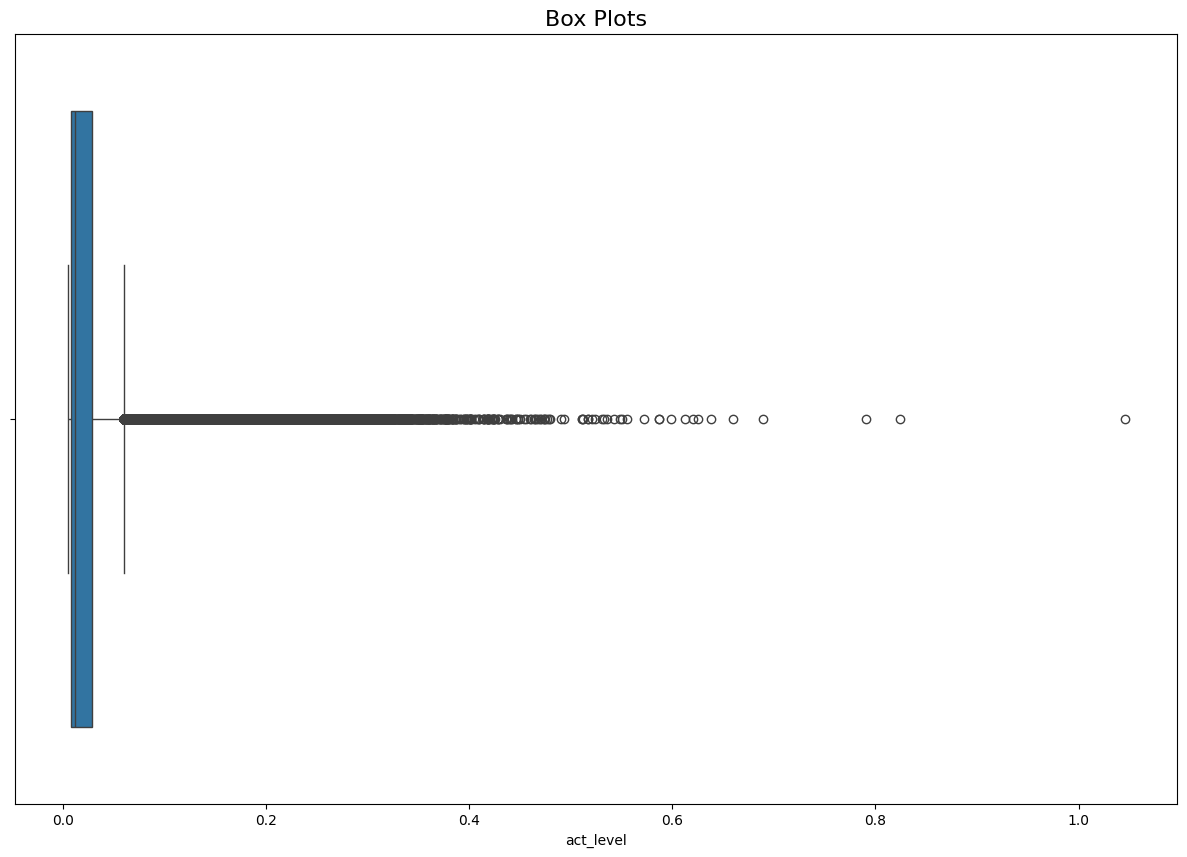

In [26]:
# ----------------------------------------------------------------- 
# FOCUSING ON POINT A. AND B.
# ----------------------------------------------------------------- 

# a. Does a value of 1.75 makes sense? Could it be that the patient was maybe just doing sport?
## Boxplot 
import seaborn as sns
import matplotlib.pyplot as plt
poll_box_activity = merged_inhale_openweather_dropped["act_level"]

plt.figure(figsize=(15, 10))
sns.boxplot(data=poll_box_activity, orient='h')
plt.title('Box Plots', fontsize=16)
plt.show()

## OUTPUT --> Based on the below plot, there are only a few values above 1.25 so I will drop them!
## Possibly an analysis of whether that's real as in if it's a recurring trend or not

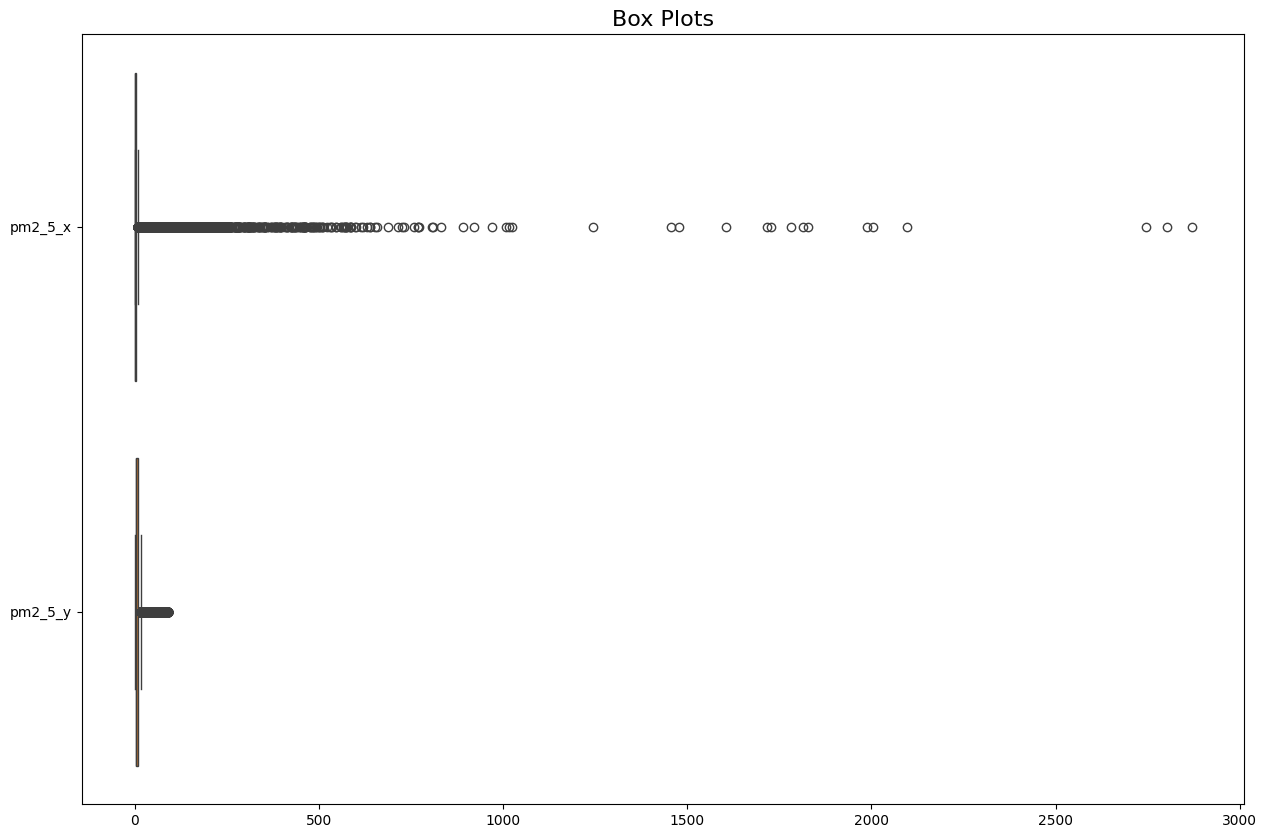

In [27]:
# ----------------------------------------------------------------- 
# FOCUSING ON POINT C.
# ----------------------------------------------------------------- 

# C. pm2_5 definitely has an outlier, this is because a max of 2245 would hurt or kill a person instantly.
## Boxplot 
import seaborn as sns
import matplotlib.pyplot as plt
columns_to_choose = ["pm2_5_x","pm2_5_y"]
poll_box_pm2_5 = merged_inhale_openweather_dropped[columns_to_choose].copy()

plt.figure(figsize=(15, 10))
sns.boxplot(data=poll_box_pm2_5, orient='h')
plt.title('Box Plots', fontsize=16)
plt.show()

## OUTPUT --> Based on the below plot, we can straight away see how pm2_5_x (which is air pollution coming from individual sensor_data)
## is more sensible to outliers. Values higher than 1000 need to be excluded since outliers.

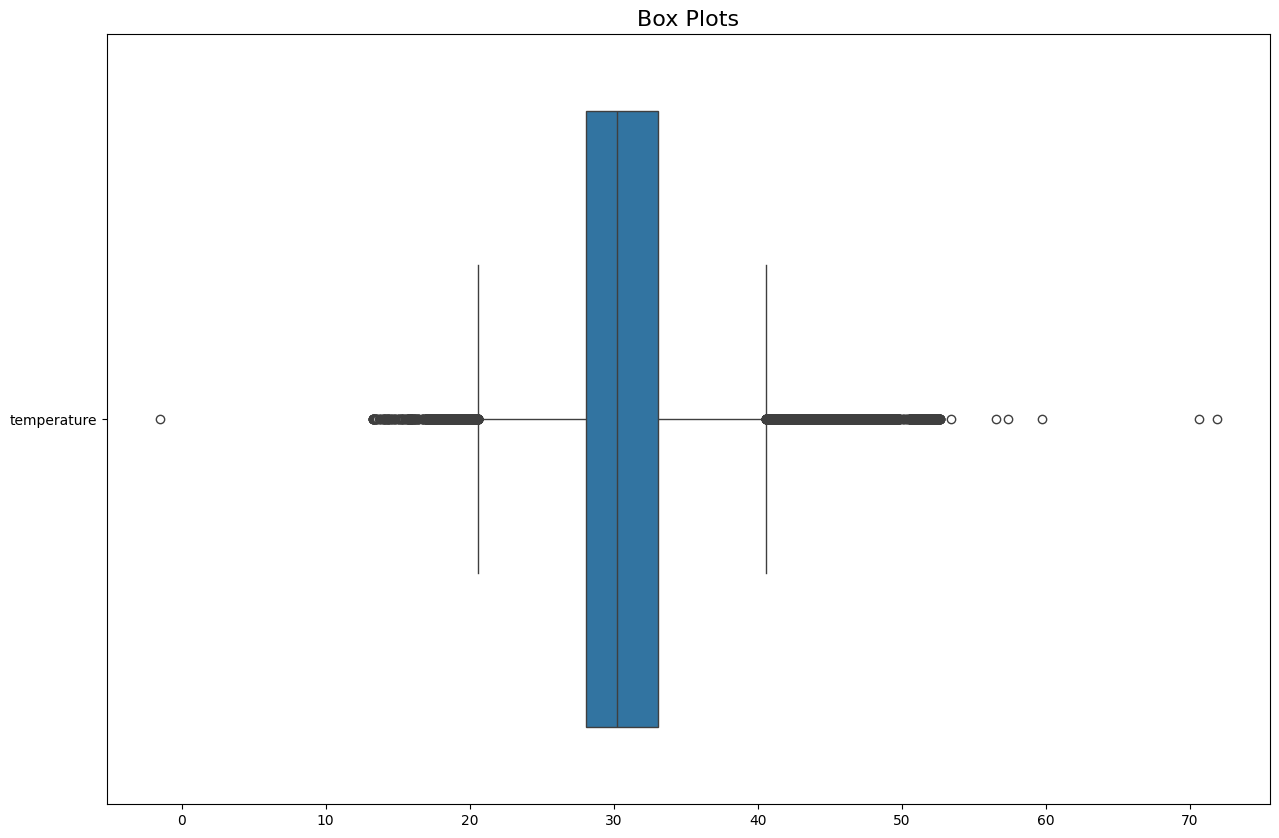

In [28]:
# ----------------------------------------------------------------- 
# FOCUSING ON POINT D.
# ----------------------------------------------------------------- 

# D. Temperature as well - since there is a massive spike
## Boxplot 
import seaborn as sns
import matplotlib.pyplot as plt
columns_to_choose = ["temperature"]
poll_box_temperature = merged_inhale_openweather_dropped[columns_to_choose].copy()

plt.figure(figsize=(15, 10))
sns.boxplot(data=poll_box_temperature, orient='h')
plt.title('Box Plots', fontsize=16)
plt.show()

## OUTPUT --> Because most of the sensors reading are in spring summer I was expecting values between 20 and 30 degrees.
## After checking the 56 degrees max value 

## After finding out the temperature of 56 degree was in March - I can confidently say it was an outlier!

merged_inhale_openweather_hot = merged_inhale_openweather_dropped[merged_inhale_openweather_dropped["temperature"] == 56.630000]

## OUTPUT --> Remove 56 degrees value!

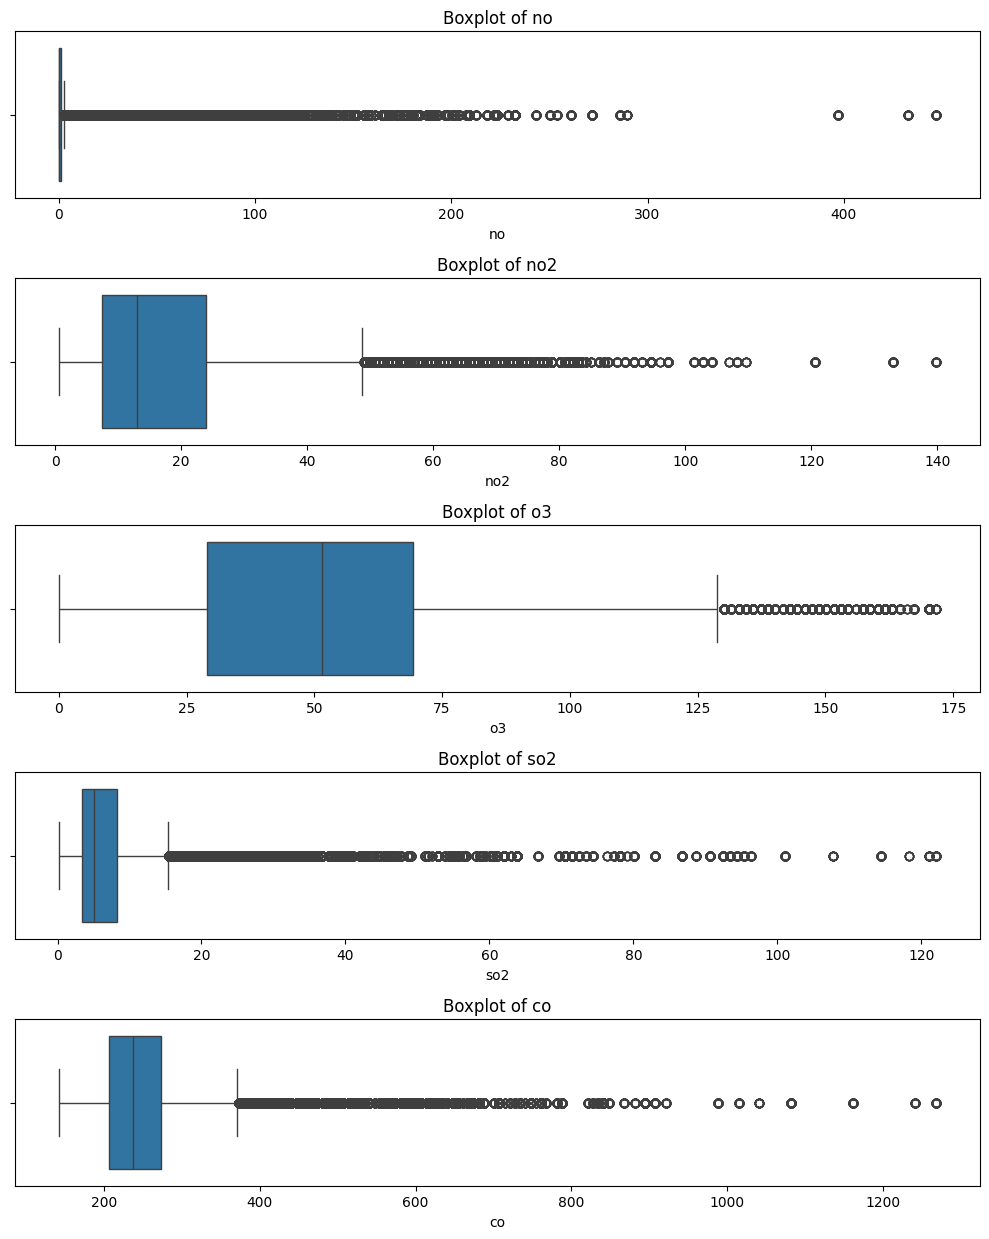

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------------------------------------------- 
# FOCUSING ON POINT E.
# ----------------------------------------------------------------- 

columns_to_choose = ["no", "no2", "o3", "so2", "co"]
poll_box_poll_overall = merged_inhale_openweather_dropped[columns_to_choose].copy()

n = len(columns_to_choose)
fig, axes = plt.subplots(n, 1, figsize=(10, 2.5 * n))  # 1 column, n rows

for i, col in enumerate(columns_to_choose):
    sns.boxplot(x=poll_box_poll_overall[col], ax=axes[i], orient='h')
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()


## OUTPUT --> For now I am removing only clear outliers!
## no < 250
## no2 < 130
## o3 < 135
## so2 < 120 
## co < 800

In [30]:
## Removing all outliers based on above findings
## A.B. ACTIVITY LEVELS: Only a few values above 1.25 so I will drop them!
## C. PM2_5 > 1000, drop
## D. TEMPERATURE: Remove 56 degress value!
## E. POLLUTION MEASURES FROM OPENWEATHER: But check if they are still there!

print(merged_inhale_openweather_dropped.columns)
print(f"Before outliers removal:{len(merged_inhale_openweather_dropped)}")

merged_inhale_openweather_act_no = merged_inhale_openweather_dropped[merged_inhale_openweather_dropped["act_level"] < 1.25]

merged_inhale_openweather_pm2_5_no = merged_inhale_openweather_act_no[merged_inhale_openweather_act_no["pm2_5_x"] < 1000]

merged_inhale_openweather_temp_no = merged_inhale_openweather_pm2_5_no[merged_inhale_openweather_pm2_5_no["temperature"] < merged_inhale_openweather_pm2_5_no["temperature"].max()]

merged_inhale_openweather_poll_tot = merged_inhale_openweather_temp_no[(merged_inhale_openweather_temp_no["no"] < 250) |
                                                                        (merged_inhale_openweather_temp_no["no2"] < 130) |
                                                                         (merged_inhale_openweather_temp_no["o3"] < 135) |
                                                                          (merged_inhale_openweather_temp_no["so2"] < 120) |
                                                                           (merged_inhale_openweather_temp_no["co"] < 800)]
        
## OUTPUT --> For now I am removing only clear outliers!
## no < 250
## no2 < 130
## o3 < 135
## so2 < 120 
## co < 800
print(f"After outliers removal:{len(merged_inhale_openweather_poll_tot)}")

Index(['patient_id', 'age', 'sex', 'timestamp', 'season_x', 'br_avg', 'br_std',
       'act_level', 'step_count', 'activity', 'latitude_x', 'longitude_x',
       'season_y', 'pm2_5_x', 'temperature', 'humidity', 'time_diff',
       'new_segment', 'segment_id', 'hour', 'dow', 'day_of_year', 'hour_sin',
       'hour_cos', 'dow_sin', 'dow_cos', 'yearly_sin', 'yearly_cos',
       'timestamp_hour', 'lat_round', 'lon_round', 'pm2_5_y', 'pm10', 'no',
       'no2', 'o3', 'so2', 'co'],
      dtype='object')
Before outliers removal:533012
After outliers removal:526502


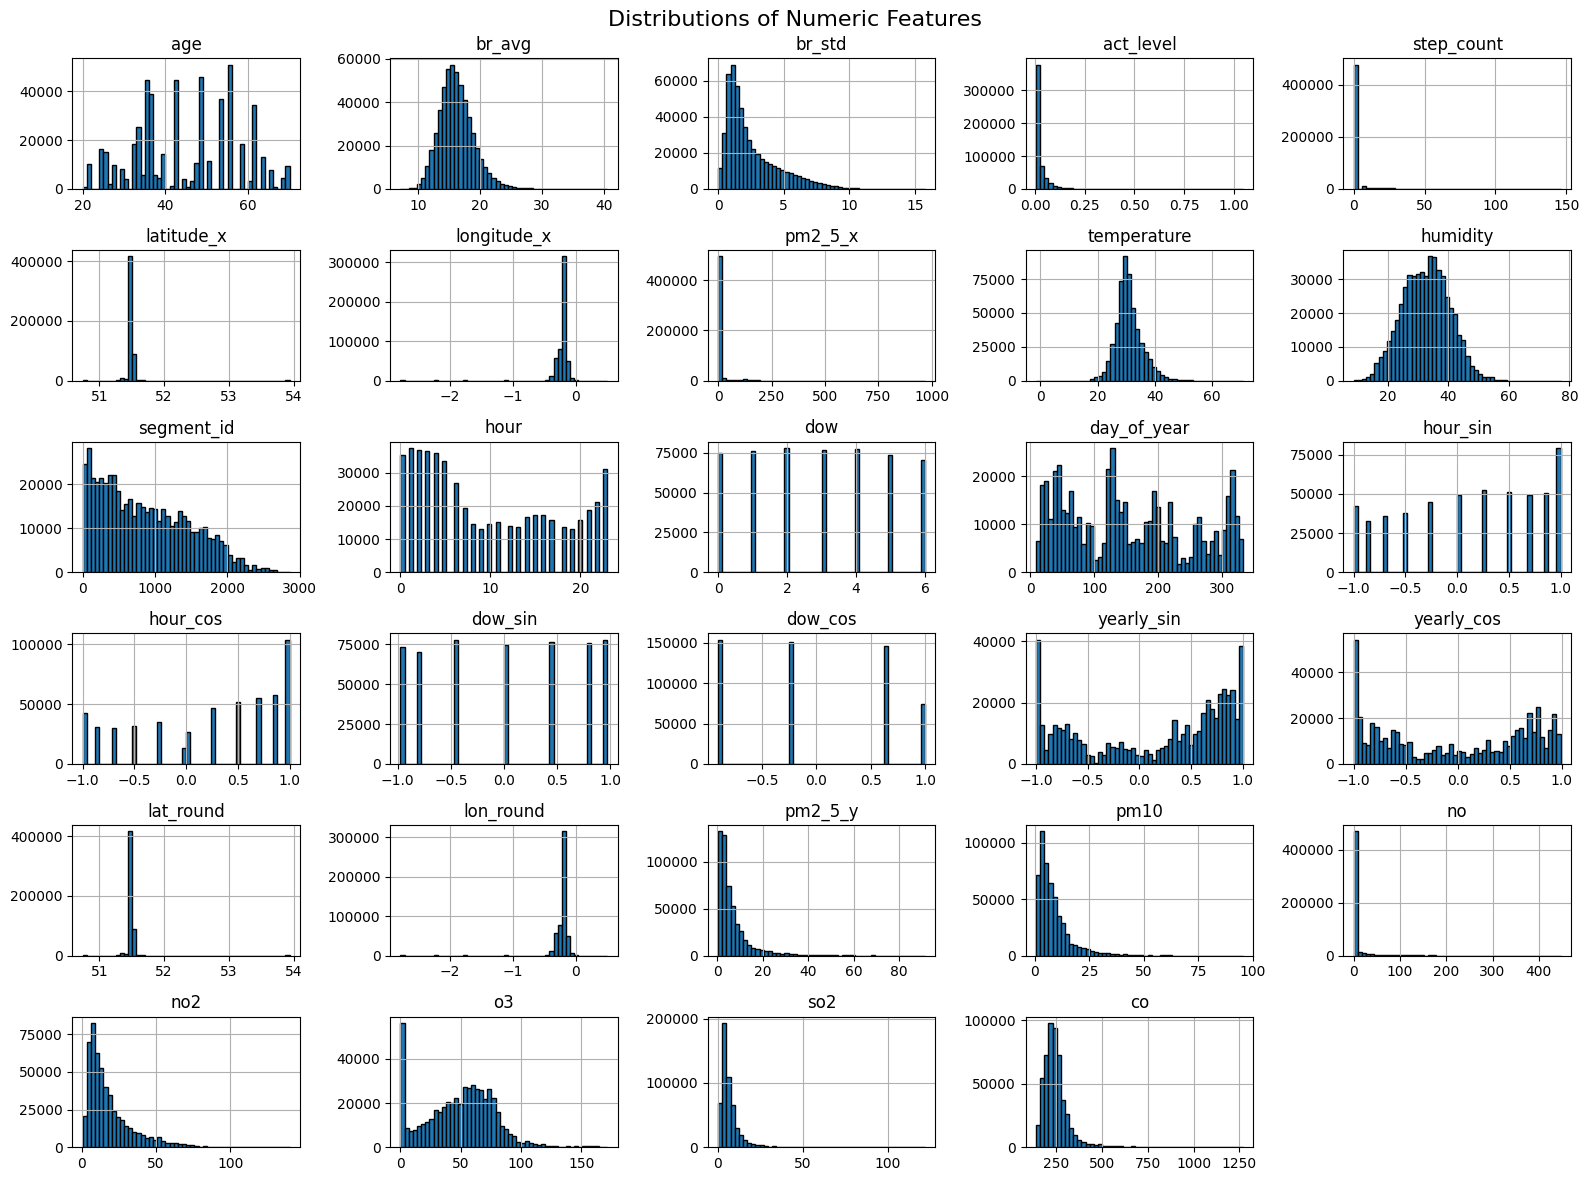

In [31]:
## When Looking at the distribution of variables we can see that:

import matplotlib.pyplot as plt
# Select only numeric columns
numeric_cols = merged_inhale_openweather_poll_tot.select_dtypes(include='number')
# Plot
numeric_cols.hist(bins=50, figsize=(16, 12), edgecolor='black')
plt.suptitle("Distributions of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

## You can see straight away how:
# - br_avg --> Need log skew
# - br_std --> Need log skew
# - act_level --> Need log skew
# - step_count --> need log skew
# - temperature --> normalisation needed
# - humidity --> normalisation needed
# - pm_2_5_y, pm10, no, no2, o3, so2, co need log skew. 

In [32]:
## DECISIONS ABOUT WHICH PATIENT TO INCLUDE/EXCLUDE

In [33]:
## Checking timestamp - Which patient_id should I consider and which should I exclude?

In [34]:
## Learning point:

## Seems like there is not enough data available here:

## NUmber of rows per patient:
# INH131	9970	16.960002	3.130395	7.811052	40.539921	0
# INH138	9746	15.807289	2.984870	8.501855	37.599060	0
# INH014	9131	15.812821	3.032257	7.912819	40.167995	0
# INH121	8588	16.614206	2.675530	7.812432	35.356556	0
# INH011	6784	17.553251	2.918031	8.658721	35.497250	0
# INH018	6580	16.528699	2.893721	8.419410	34.104557	0
# INH130	5137	17.778346	2.824248	8.706172	34.690540	0
# INH027	4926	17.645728	3.140574	8.523079	40.167995	0
# INH008	4339	17.394300	2.955554	8.420137	39.884861	0
# INH028	3260	15.757704	3.698346	7.463918	41.413460	0
# INH132	2457	16.531736	3.289066	8.539427	37.697220	0
# INH119	982	16.197776	2.784998	9.889407	30.739164	0

In [35]:
patient_checking_data = merged_inhale_openweather_poll_tot.copy()

In [ ]:
patient_checking_data

In [ ]:
## Checking timestamp:
patient_stats = (
    patient_checking_data
    .groupby("patient_id")
    .agg(
        num_rows=('br_avg', 'count'),
        br_avg_mean=('br_avg', 'mean'),
        br_avg_std=('br_avg', 'std'),
        br_avg_min=('br_avg', 'min'),
        br_avg_max=('br_avg', 'max'),
        missing_rows=('br_avg', lambda x: x.isna().sum())
    )
    .sort_values("num_rows", ascending=False)
)

patient_stats


In [ ]:
import pandas as pd
from tqdm import tqdm

def compute_gaps(df, patient_col='patient_id', time_col='timestamp', freq='1min'):
    gap_info = []

    for pid, group in tqdm(df.groupby(patient_col), desc="Analyzing gaps"):
        group = group.sort_values(time_col)
        time_index = pd.to_datetime(group[time_col])
        expected_index = pd.date_range(start=time_index.min(), end=time_index.max(), freq=freq)

        missing = expected_index.difference(time_index)
        gap_info.append({
            'patient_id': pid,
            'num_rows': len(group),
            'start': time_index.min(),
            'end': time_index.max(),
            'expected_points': len(expected_index),
            'actual_points': len(time_index),
            'missing_points': len(missing),
            'missing_ratio': len(missing) / len(expected_index)
        })

    return pd.DataFrame(gap_info)

# Run on your clean_data
gap_df = compute_gaps(patient_checking_data)

# View sorted by most missing
gap_df.sort_values("missing_ratio", ascending=False)

In [39]:
tidal_volume = pd.read_csv("inhale_tidal_vol.csv")

In [40]:
tidal_volume["cubic_meterers_tv"] = tidal_volume["V_t"] / 1000000

In [ ]:
tidal_volume

In [ ]:
merged_inhale_openweather_poll_tot

In [43]:
merged_inhale_openweather_poll_tot.columns

Index(['patient_id', 'age', 'sex', 'timestamp', 'season_x', 'br_avg', 'br_std',
       'act_level', 'step_count', 'activity', 'latitude_x', 'longitude_x',
       'season_y', 'pm2_5_x', 'temperature', 'humidity', 'time_diff',
       'new_segment', 'segment_id', 'hour', 'dow', 'day_of_year', 'hour_sin',
       'hour_cos', 'dow_sin', 'dow_cos', 'yearly_sin', 'yearly_cos',
       'timestamp_hour', 'lat_round', 'lon_round', 'pm2_5_y', 'pm10', 'no',
       'no2', 'o3', 'so2', 'co'],
      dtype='object')

In [44]:
merged_tidal = merged_inhale_openweather_poll_tot.merge(tidal_volume, on = ["patient_id"])
merged_tidal.columns

merged_tidal.drop(columns=['V_t', 'pm2_5_y'], inplace=True)

# ## Do checks to see if everything works fine then multiply!

In [ ]:
merged_tidal["inhale_tv"] = merged_tidal["cubic_meterers_tv"] * merged_tidal["pm2_5_x"]
merged_tidal

## Data Preprocessing Pipeline:

In [46]:
## Here dropping timestamp - it will be represented with sin cosin

merged_tidal.drop(columns=[
    "timestamp", "timestamp_hour"], inplace=True)

print(len(merged_tidal.columns))
merged_tidal.dtypes
print(merged_inhale_openweather_poll_tot.columns)



39
Index(['patient_id', 'age', 'sex', 'timestamp', 'season_x', 'br_avg', 'br_std',
       'act_level', 'step_count', 'activity', 'latitude_x', 'longitude_x',
       'season_y', 'pm2_5_x', 'temperature', 'humidity', 'time_diff',
       'new_segment', 'segment_id', 'hour', 'dow', 'day_of_year', 'hour_sin',
       'hour_cos', 'dow_sin', 'dow_cos', 'yearly_sin', 'yearly_cos',
       'timestamp_hour', 'lat_round', 'lon_round', 'pm2_5_y', 'pm10', 'no',
       'no2', 'o3', 'so2', 'co'],
      dtype='object')


In [47]:
merged_tidal.dtypes

patient_id                    object
age_x                          int64
sex_x                         object
season_x                      object
br_avg                       float64
br_std                       float64
act_level                    float64
step_count                     int64
activity                      object
latitude_x                   float64
longitude_x                  float64
season_y                      object
pm2_5_x                      float64
temperature                  float64
humidity                     float64
time_diff            timedelta64[ns]
new_segment                     bool
segment_id                     int64
hour                           int32
dow                            int32
day_of_year                    int32
hour_sin                     float64
hour_cos                     float64
dow_sin                      float64
dow_cos                      float64
yearly_sin                   float64
yearly_cos                   float64
l

In [48]:
print(len(merged_tidal.columns))

39


In [ ]:
# Filter out patients with high missingness
to_exclude = [
    "INH130", "INH020", "INH008", "INH129", "INH124", 
    "INH005", "INH126", "INH019", "INH026", "INH132", 
    "INH016", "INH136"
]
merged_no_leak = merged_tidal[
    ~merged_tidal["patient_id"].isin(to_exclude)
]

merged_no_leak.columns
# # Split patients into train and test
# unique_pids = merged_no_leak['patient_id'].unique()
# np.random.shuffle(unique_pids)
# split_idx = int(0.7 * len(unique_pids))

# train_pids = unique_pids[:split_idx]
# test_pids = unique_pids[split_idx:]

# train_df = merged_no_leak[merged_no_leak['patient_id'].isin(train_pids)].copy()
# test_df = merged_no_leak[merged_no_leak['patient_id'].isin(test_pids)].copy()

Index(['patient_id', 'age_x', 'sex_x', 'season_x', 'br_avg', 'br_std',
       'act_level', 'step_count', 'activity', 'latitude_x', 'longitude_x',
       'season_y', 'pm2_5_x', 'temperature', 'humidity', 'time_diff',
       'new_segment', 'segment_id', 'hour', 'dow', 'day_of_year', 'hour_sin',
       'hour_cos', 'dow_sin', 'dow_cos', 'yearly_sin', 'yearly_cos',
       'lat_round', 'lon_round', 'pm10', 'no', 'no2', 'o3', 'so2', 'co',
       'sex_y', 'age_y', 'cubic_meterers_tv', 'inhale_tv'],
      dtype='object')

In [52]:
cols = ["age_x", "br_avg", "br_std" , 'act_level', 'step_count', 'latitude_x', 'longitude_x', 'pm2_5_x', 'humidity', 'pm10', 'no',
       'o3', 'so2', 'co', 'inhale_tv']

corr_dataframe = merged_no_leak[cols]

corr = corr_dataframe.corr()


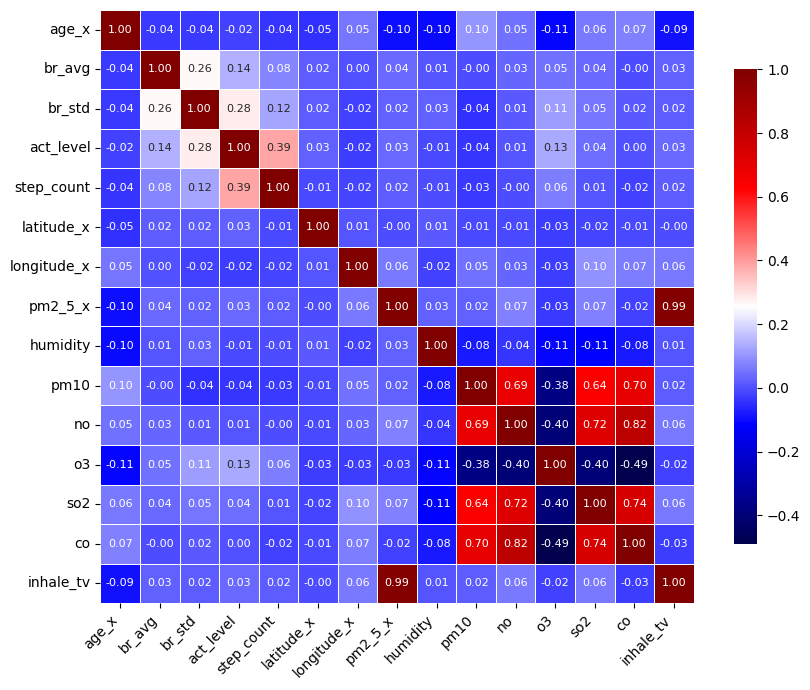

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,7))    # or whatever aspect ratio works for you
sns.heatmap(
    corr,
    cmap="seismic",
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink":0.8},
    annot_kws={"fontsize":8}
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
train_df["patient_id"].unique()

In [ ]:
train_df.to_csv("train_data_not_normalised.csv")
test_df.to_csv("test_data_not_normalised.csv")

In [ ]:
print("ciao")

In [ ]:
ciao

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# === Column Groups ===
cyclical_cols = ['yearly_sin', 'yearly_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
log_transform_cols = ["br_avg", "br_std", "act_level", "step_count",
                      "pm2_5_x", "pm2_5_y", "pm10", "no", "no2", "o3", "so2", "co"]
categorical_cols = ['sex', 'activity', 'health', 'season', 'is_weekend']
passthrough_cols = ['patient_id']
scalable_numeric = ['age', 'temperature', 'humidity', 'month', 'week_of_year', 'day_of_year',
                    'latitude_x', 'longitude_x', 'lat_round', 'lon_round']


log_custom = FunctionTransformer(np.log1p, feature_names_out='one-to-one')

log_transformer = Pipeline([
    ('log', log_custom)
])

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Fit OHE on training only!
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(train_df[categorical_cols])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', ohe)
])


In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('log', log_transformer, log_transform_cols),
    ('num', numeric_transformer, scalable_numeric),
    ('cat', categorical_transformer, categorical_cols),
    ('cyclical', 'passthrough', cyclical_cols),
    ('patient_id', 'passthrough', passthrough_cols)
])

# ✅ Only fit on train!
preprocessor.fit(train_df)


In [ ]:
def transform_per_patient(df, preprocessor):
    processed_list = []
    for pid in tqdm(df['patient_id'].unique(), desc="Transforming patients"):
        df_patient = df[df['patient_id'] == pid].copy()
        transformed = preprocessor.transform(df_patient)
        cols = preprocessor.get_feature_names_out()
        df_transformed = pd.DataFrame(transformed, columns=cols)
        processed_list.append(df_transformed)
    result = pd.concat(processed_list, ignore_index=True)
    
    # Clean column names
    clean_columns = [col.replace('log__', '')
                         .replace('cat__', '')
                         .replace('num__', '')
                         .replace('cyclical__', '')
                         .replace('patient_id__', '')
                     for col in result.columns]
    result.columns = clean_columns
    
    return result.fillna(0)  # fill edge NaNs safely


In [ ]:
processed_train_df = transform_per_patient(train_df, preprocessor)
processed_test_df = transform_per_patient(test_df, preprocessor)

In [ ]:
processed_train_df.drop_duplicates()
processed_test_df.drop_duplicates()
processed_train_df.to_csv("processed_train_normalised.csv")
processed_test_df.to_csv("processed_test_normalised.csv")

In [ ]:
processed_train_df["patient_id"].unique()

In [ ]:
processed_test_df["patient_id"].unique()

In [ ]:
STOP HERE

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from tqdm import tqdm

# === Column Groups ===
cyclical_cols = ['yearly_sin', 'yearly_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
log_transform_cols = ["br_avg", "br_std", "act_level", "step_count",
                      "pm2_5_x", "pm2_5_y", "pm10", "no", "no2", "o3", "so2", "co"]
categorical_cols = ['sex', 'activity', 'health', 'season', 'is_weekend']
passthrough_cols = ['patient_id']
scalable_numeric = ['age', 'temperature', 'humidity', 'month', 'week_of_year', 'day_of_year',
                    'latitude_x', 'longitude_x', 'lat_round', 'lon_round']

# === Transformers ===
log_custom = FunctionTransformer(np.log1p, feature_names_out='one-to-one')

log_transformer = Pipeline([
    ('log', log_custom)
])

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# === Pre-fit OneHotEncoder on full data
full_ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
full_ohe.fit(merged_inhale_openweather_poll_tot[categorical_cols])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', full_ohe)
])

# === Full Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('log', log_transformer, log_transform_cols),
    ('num', numeric_transformer, scalable_numeric),
    ('cat', categorical_transformer, categorical_cols),
    ('cyclical', 'passthrough', cyclical_cols),
    ('patient_id', 'passthrough', passthrough_cols)
])

# ✅ Fit ONCE on full dataset
preprocessor.fit(merged_inhale_openweather_poll_tot)

# === Transform each patient separately
patient_ids = merged_inhale_openweather_poll_tot['patient_id'].unique()
processed_list = []

for pid in tqdm(patient_ids):
    df_patient = merged_inhale_openweather_poll_tot[
        merged_inhale_openweather_poll_tot['patient_id'] == pid
    ].copy()
    transformed = preprocessor.transform(df_patient)
    cols = preprocessor.get_feature_names_out()

    df_processed = pd.DataFrame(transformed, columns=cols)
    processed_list.append(df_processed)

# === Concatenate All Patients
processed_merged_dataset = pd.concat(processed_list, ignore_index=True)

# === Clean Column Names
clean_columns = [col.replace('log__', '')
                     .replace('cat__', '')
                     .replace('num__', '')
                     .replace('cyclical__', '')
                     .replace('patient_id__', '')
                 for col in processed_merged_dataset.columns]
processed_merged_dataset.columns = clean_columns

# === Fill any remaining NaNs (edge cases)

print(processed_merged_dataset.isna().sum())
processed_merged_dataset = processed_merged_dataset.fillna(0)

print("✅ Preprocessing complete. Shape:", processed_merged_dataset.shape)

In [ ]:
processed_merged_dataset

In [ ]:
processed_merged_dataset.drop_duplicates()
processed_merged_dataset.to_csv("processed_merged_dataset_normalise_per_user.csv")

In [ ]:
print("ciao")

In [ ]:
## Appendix

In [ ]:
# cyclical_cols = ['yearly_sin', 'yearly_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
# log_transform_cols = ["br_avg", "br_std", "act_level", "step_count",
#                       "pm2_5_x", "pm2_5_y", "pm10", "no", "no2", "o3", "so2", "co"]
# categorical_cols = ['sex', 'activity', 'health', 'season', 'is_weekend']
# passthrough_cols = ['patient_id']

# scalable_numeric = ['age', 'temperature', 'humidity', 'month', 'week_of_year', 'day_of_year', 'latitude_x', 'longitude_x', 'lat_round', 'lon_round']


In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
# import numpy as np
# from sklearn.compose import ColumnTransformer

# numeric_transformer = Pipeline([
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
# ])


# # Categorical transformer
# categorical_transformer = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('encoder', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Log transformer
# def log_function(x):
#     return np.log1p(x)

# log_custom = FunctionTransformer(log_function, feature_names_out='one-to-one')

# log_transformer = Pipeline([
#     ('log_transform', log_custom)
# ])



In [ ]:
# ## Now puttin everything together in my pipeline!
# preprocessor = ColumnTransformer(transformers=[
#     ('log', log_transformer, log_transform_cols),
#     ('num', numeric_transformer, scalable_numeric),
#     ('cat', categorical_transformer, categorical_cols),
#     ('cyclical', 'passthrough', cyclical_cols),
#     ('patient_id', 'passthrough', passthrough_cols)
# ])

# preprocessor

In [ ]:
# import joblib
# joblib.dump(preprocessor, 'preprocessor.pkl')

In [ ]:
# from tqdm import tqdm

# patient_ids = merged_inhale_openweather_poll_tot['patient_id'].unique()
# processed_list = []

# for pid in tqdm(patient_ids):
#     df_patient = merged_inhale_openweather_poll_tot[merged_inhale_openweather_poll_tot['patient_id'] == pid].copy()
    
#     # Apply preprocessing pipeline independently for each patient
#     processed = preprocessor.fit_transform(df_patient)
    
#     # Reconstruct DataFrame
#     cols = preprocessor.get_feature_names_out()
#     df_processed = pd.DataFrame(processed, columns=cols)
#     df_processed['patient_id'] = pid  # Add back patient ID
    
#     processed_list.append(df_processed)

# # Concatenate all patients back together
# processed_merged_dataset = pd.concat(processed_list, ignore_index=True)

# # Optional: Clean column names
# clean_columns = [col.replace('log__', '').replace('cat__', '').replace('num__', '').replace('cyclical__','') for col in processed_merged_dataset.columns]
# processed_merged_dataset.columns = clean_columns


In [ ]:
processed_merged_dataset

In [ ]:
# # clean_columns = [col.replace('log__', '').replace('cat__', '').replace('num__', '').replace('cyclical__','').replace('latlon__','')  for col in processed_merged_dataset.columns]
# # processed_merged_dataset.columns = clean_columns

# for col in processed_merged_dataset.columns:
#     processed_merged_dataset[col] = pd.to_numeric(processed_merged_dataset[col], errors='ignore')
# processed_merged_dataset.drop_duplicates()
# processed_merged_dataset.to_csv("processed_merged_dataset_normalise_per_user.csv")

# APPENDIX

## RESPIRATORY DATA

In [ ]:
# respiratory_data = read_file(file=files.iloc[9])
# respiratory_data.head(5)

In [ ]:
# ## Let's check which columns are available
# respiratory_data.dtypes
# ## There are 57 different patient_id
# print(len(resp_data["patient_id"].unique()), resp_data.dtypes)

In [ ]:
# respiratory_data = respiratory_data.drop(columns = ["Unnamed: 0"])

In [ ]:
# import numpy as np
# import pandas as pd

# # Classifying each patient as 'ashmatic' or 'healthy' based on ID pattern
# respiratory_data["health"] = np.where(
#     respiratory_data["patient_id"].str[3] == "0", 
#     "ashmatic", 
#     "healthy"
# )

# # Ensuring 'timestamp' column is in datetime format
# respiratory_data['timestamp'] = pd.to_datetime(respiratory_data['timestamp'])

# # Extract time-based features
# respiratory_data['is_weekend'] = respiratory_data['timestamp'].dt.dayofweek.isin([5, 6])
# respiratory_data['month'] = respiratory_data['timestamp'].dt.month
# respiratory_data['week_of_year'] = respiratory_data['timestamp'].dt.isocalendar().week

# # Cyclical encoding for hour of day and day of week this is because if not the model will see 23pm and 1am as far away 
# respiratory_data['hour_sin'] = np.sin(2 * np.pi * respiratory_data['timestamp'].dt.hour / 24)
# respiratory_data['hour_cos'] = np.cos(2 * np.pi * respiratory_data['timestamp'].dt.hour / 24)

# # Cyclical encoding for day of week
# respiratory_data['dow_sin'] = np.sin(2 * np.pi * respiratory_data['timestamp'].dt.dayofweek / 7)
# respiratory_data['dow_cos'] = np.cos(2 * np.pi * respiratory_data['timestamp'].dt.dayofweek / 7)

# respiratory_data = respiratory_data.drop(columns=["timestamp"])

# # Now your respiratory_data has clean, ML-friendly time embeddings
# respiratory_data.head()

In [ ]:
# respiratory_data["sex"].value_counts()

In [ ]:
# ## I need to understand the timeline per id
# timeline_per_id = (
#     resp_data
#     .groupby("patient_id")["timestamp"]
#     .agg(["min", "max"])
#     .reset_index()
# ).copy()
# print(timeline_per_id)

## Timestamp
## Every id has different timestamp - how is this going to impact my model?


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Filter data for specific patient
# patient_id = "INH029"
# measure = "br_avg"
# resp_data_patient = resp_data[resp_data["patient_id"] == patient_id].copy()

# # # Ensure timestamp is in datetime format (if not already)
# resp_data_patient['timestamp'] = pd.to_datetime(resp_data_patient['timestamp'])
# # pd.to_datetime(resp_data001['timestamp'])

# # Set timestamp as index (for clean plotting)
# resp_data_patient.set_index('timestamp', inplace=True)

# # Create the plot with proper timestamp handling
# plt.figure(figsize=(15, 6))
# resp_data_patient[measure].plot(title=f'{measure}  Over Time for Patient {patient_id}')

# # Customize x-axis to show timestamps clearly
# plt.xlabel('Timestamp')  # Explicit x-label
# plt.ylabel(measure)
# plt.grid(True)

# # Improve x-axis tick formatting for better readability
# plt.gcf().autofmt_xdate()  # Auto-format dates to prevent overlap

# plt.tight_layout()
# plt.show()

# Participants
## a. How many participants do we have?
## b. Males vs Females?
## c. What about their age?
## d. Wich activity do they do?
## e. Which features are more or less correlated?

In [ ]:
# ## a. How many participants do we have?
# print(len(resp_data["patient_id"].unique()))

# ## b. I am dropping duplicates because it's a time-series dataset
# ## There are more females than males - is this going to imbalance the dataset - does it matter?
# gender_counts = resp_data.drop_duplicates(subset="patient_id")["sex"].value_counts()
# print(gender_counts)

# ## c. In relation to their age - there are slightly more individuals between the age of 35 and 50 
# ## then other age brackets
# import matplotlib.pyplot as plt

# # Get unique ages per patient_id
# unique_ages = resp_data.drop_duplicates(subset="patient_id")["age"]

# # Plot histogram
# plt.figure(figsize=(10, 6))
# plt.hist(unique_ages, bins=10, edgecolor='black', color='skyblue')
# plt.title("Age Distribution of Participants (One per ID)")
# plt.xlabel("Age")
# plt.ylabel("Count")
# plt.grid(axis='y', alpha=0.5)
# plt.show()

# ## d. What are the activity types?
# activity_counts = resp_data.drop_duplicates(subset="patient_id")["activity"].value_counts()
# print(activity_counts)

In [ ]:
# ## e. Which features are more or less correlated?
# ## It seems like that only activity levels are strongly correlated
# # Correct way to drop multiple columns
# import pandas as pd

# # Convert categorical columns to numerical (one-hot encoding)
# resp_data_encoded = pd.get_dummies(
#     resp_data,
#     columns=["sex", "activity", "season"],  # Replace with your column names
#     drop_first=True  # Avoid multicollinearity (e.g., Female=0 → Male=1)
# )

# # Now drop other non-numeric columns (e.g., patient_id, timestamp)
# resp_data_corr = resp_data_encoded.drop(columns=["Unnamed: 0", "patient_id", "timestamp"])

# # Compute correlation
# corr = resp_data_corr.corr()
# plt.figure(figsize=(12, 8))
# sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
# plt.title("Feature Correlation Matrix")
# plt.show()

# POLLUTION DATA
## a. How many participants do we have? For how long?
## b. Where is the data located by participant
## c. Which features are more or less correlated?
## d. Generic trend of pollution vs location  
## e. Pollution and season
## f  Pollution vs time of day
## g. Pollution vs temperature and humifity

In [ ]:
# pollution_data = read_file(file=files.iloc[8])
# pollution_data.head(5)

In [ ]:
# print(pollution_data["season"].value_counts())
# print(pollution_data["patient_id"].unique().copy())
# ## a. How many participants do we have?
# print(len(pollution_data["patient_id"].unique()))

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# poll_box = pollution_data.drop(columns=["Unnamed: 0"])
# poll_box = poll_box[poll_box["patient_id"] == "INH002"]
# plt.figure(figsize=(15, 10))
# sns.boxplot(data=poll_box, orient='h')
# plt.title('Box Plots', fontsize=16)
# plt.show()

In [ ]:
# ## Testing
# bad_reading = pollution_data.groupby('patient_id')['pm2_5'].agg(['max','count']).sort_values('max', ascending=False)
# bad_reading


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.colors import BoundaryNorm

# pollution_data = pollution_data[pollution_data["pm2_5"] < 501]
# # 1) Define your PM₂.₅ bins at real‐world breakpoints
# bins = [0,10, 25, 50, 100, 200, 500]

# # 2) Create a norm that maps each bin to a distinct color
# norm = BoundaryNorm(bins, ncolors=256, clip=True)

# # 3) Clip your data to the top end
# x = pollution_data.longitude
# y = pollution_data.latitude
# c = pollution_data.pm2_5.clip(upper=500)

# # 4) Plot with 'turbo' (or swap to 'cividis', 'viridis', etc.)
# plt.figure(figsize=(10,8))
# sc = plt.scatter(
#     x, y,
#     c=c,
#     cmap='turbo',
#     norm=norm,
#     s=25,          # slightly bigger points
#     edgecolors='k',# thin black border for contrast
#     linewidths=0.2,
#     alpha=0.9
# )

# # 5) Colorbar ticks at exactly your bin edges
# cb = plt.colorbar(sc, boundaries=bins, ticks=bins)
# cb.set_label('PM₂.₅ (µg/m³), binned')

# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('PM₂.₅ by Latitude-Longitude London spotlight')
# plt.grid(True, linestyle='--', linewidth=0.5)
# plt.savefig("London_pollution.jpeg") 
# plt.show()

In [ ]:
# ## PM2.5 by time of day?
# import pandas as pd
# import matplotlib.pyplot as plt

# ## Time between 6pm to 8pm is the one with the highest exposure to air pollution!

# # 1) Make sure your timestamp is a proper datetime
# pollution_data['timestamp'] = pd.to_datetime(pollution_data['timestamp'])

# # 2) Extract hour of day
# pollution_data['hour'] = pollution_data['timestamp'].dt.hour

# # 3) Compute the mean (and maybe the ±1 σ envelope) by hour
# hourly = pollution_data.groupby('hour')['pm2_5'].agg(['mean','std','count']).reset_index()

# # 4) Plot
# plt.figure(figsize=(10,5))
# plt.plot(hourly['hour'], hourly['mean'], marker='o', lw=2, label='Mean PM₂.₅')
# # plt.fill_between(hourly['hour'],
# #                  hourly['mean'] - hourly['std'],
# #                  hourly['mean'] + hourly['std'],
# #                  color='C0', alpha=0.2,
# #                  label='±1 σ')
# plt.xticks(range(0,24))
# plt.xlabel('Hour of Day')
# plt.ylabel('PM₂.₅ (µg/m³)')
# plt.title('Average Daily Cycle of PM₂.₅')
# plt.grid(True, ls='--', alpha=0.5)
# plt.legend()
# plt.savefig("PM₂.₅ average daily cycle.jpeg") 
# plt.show()


In [ ]:
# ## How about Pm2.5 by season

# ## Higher in the winter as expected 

# # compute count, mean, std, min, max by season
# print(pollution_data.groupby("season")["pm2_5"]
#       .describe()[["count","mean","std","min","max"]])


In [ ]:
# ## In term of feature correlation
# ## c. not much to say about it but maybe a light correlation between temperature and humidity?
# import pandas as pd

# # # Convert categorical columns to numerical (one-hot encoding)
# poll_data_encoded = pd.get_dummies(
#     pollution_data,
#     columns=["season"]
# )
# # Now drop other non-numeric columns (e.g., patient_id, timestamp)

# pollution_data.head()

# poll_data_corr = poll_data_encoded.drop(columns=["Unnamed: 0", "patient_id", "timestamp"])

# # Compute correlation
# corr = poll_data_corr.corr()
# plt.figure(figsize=(12, 8))
# sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
# plt.title("Feature Correlation Matrix")
# plt.show() 


# Data Prepocessing:
## a. Outliers removal 
## b. Dropping nans 
## c. Standardisation but wait and do altogether

# RESPIRATORY DATA

In [ ]:
# ## Checking whether there are any outliers!
# ## The problem with this approach is that in healthcare applications outliers are very important to maintain
# ## This is because they normally tell a story about some peculiarity
# ## The only ones that I want to remove are due to calibration
# # Maybe something on step_count?

# import seaborn as sns
# box_resp_data = resp_data.drop(columns=["Unnamed: 0"]).copy()
# plt.figure(figsize=(15, 10))
# sns.boxplot(data=box_resp_data, orient='h')
# plt.title('Box Plots', fontsize=16)
# plt.show()

In [ ]:
# ## Let's checl how many nans
# print(resp_data.isnull().sum() / len(resp_data) * 100)

## POLLUTION DATA

In [ ]:
# ## From the box plot below - there are some obious outliers in pm2.5

# import seaborn as sns
# box_poll_data = pollution_data.drop(columns=["Unnamed: 0"]).copy()
# plt.figure(figsize=(15, 10))
# sns.boxplot(data=box_poll_data, orient='h')
# plt.title('Box Plots', fontsize=16)
# plt.show()

In [ ]:
# ## Let's checl how many nans
# print(pollution_data.isnull().sum() / len(pollution_data) * 100)

In [ ]:
# ## Let's try a feature correlation!
# # Convert categorical columns to numerical (one-hot encoding)
# merged_data_encoded = pd.get_dummies(
#     merged_data,
#     columns=["season", "activity", "sex"],  # Replace with your column names
#     drop_first=True  
# )
# # Now drop other non-numeric columns (e.g., patient_id, timestamp)
# merged_data_corr = merged_data_encoded.drop(columns=["Unnamed: 0_x", "patient_id", "timestamp", "Unnamed: 0_y"])

# # Compute correlation
# corr = merged_data_corr.corr()
# plt.figure(figsize=(12, 8))
# sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
# plt.title("Feature Correlation Matrix")
# plt.show() 


APPENDIX

<h2 style="color:#0074D9;">4. List the fields (clinical variables) of a study.</h2>

In [ ]:
# from pydmp import list_fields
# fields = list_fields(study_id=study_id, format='df')
# fields

<h2 style="color:#0074D9;">5. Fetch the data of fields of a study.</h2>

In [ ]:
# from pydmp import list_data
# data = list_data(study_id=study_id, field_ids=['File_Study_File'], format='df')
# data

<h2 style="color:#0074D9;">6. Run your own analysis.</h2>

In [ ]:
## Focus resp_data.csv